# Fig 5: Prediction of cell-to-cell variability from fitted models


This notebook is used to compare the fitted models to the gaussian process output

# Setup and load data

In [2]:
using CSV,DataFrames,Distributions,StatsBase,PythonPlot,Random,Tables
using DifferentialEquations
include("./../src/GrowthTraceTools.jl")
using .GrowthTraceTools
cd(dirname(@__FILE__))

## Load experimental data

In [3]:
# raw data
data_raw = CSV.read("./../output/data_processed.csv",DataFrames.DataFrame);

data_gp = CSV.read("./../output/gp/data/preds.csv",DataFrame)
lineages = unique(data_gp.lineage);
lengths = vcat([
    length(
        unique(data_gp[data_gp.lineage .== lineages[i],:position])
        ) .*
    ones(
        length(
            data_gp[data_gp.lineage .== lineages[i],:time]
            )
        ) 
    for i in eachindex(lineages)]...)
data_gp[:,:length] = lengths
data_gp = data_gp[data_gp.length .>=9,:]
lineages = unique(data_gp.lineage);
unique(data_gp.length)
names(data_gp)

14-element Vector{String}:
 "matern32_cell"
 "matern32_cell_var"
 "matern32_cell_x"
 "matern32_cell_x_var"
 "matern32_flucs"
 "matern32_flucs_var"
 "matern32_flucs_x"
 "matern32_flucs_x_var"
 "time"
 "position"
 "linear"
 "lineage"
 "age"
 "length"

# Prediction of variance of cell-cycle averaged growth

## Setup

we load simulated data which has been fit to instantaneous growth rates

In [4]:
data_cells = combine(groupby(data_gp,[:lineage,:position]),
    :matern32_flucs_x=>mean=>:gr,
    :time=>(x->x[end]-x[1])=>:gt,:length=> mean => :length);
lineages = unique(data_cells.lineage)
# get time interval for predicted arrays
dt = mean(diff(data_gp[data_gp.lineage .== lineages[1],:time])); 

# get sims
sims = CSV.read("./../output/fig5_sims.csv",DataFrame);
sims_cells = combine(groupby(sims,[:lineage_original,:σDN,:replicate,:position]),
    :λ=>mean=>:gr,
    :time=>(x->x[end]-x[1])=>:gt,:length=> mean => :length);
sims_cells[:,:lineage] = sims_cells.lineage_original



# # get sim after gp
# sims_gp = CSV.read("./../output/fig5_sims_gp_preds.csv",DataFrame);
# sims_cells_gp = combine(groupby(sims_gp,[:lineage,:position]),
#     :matern32notrend_flucs_x=>mean=>:gr,
#     :time=>(x->x[end]-x[1])=>:gt);

# GrowthTraceTools.map_lineage_col!(sims,sims_gp,:σDN);
# GrowthTraceTools.map_lineage_col!(sims,sims_gp,:lineage_original);

6687-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [5]:
length(unique(sims[sims.lineage_original .== 1,:].lineage))

100

In [6]:
unique(sims.replicate)

20-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19
 20

### Check distribution of growth rates in simulated data looks reasonable 

/Users/elevien/Dartmouth College Dropbox/Ethan Levien/RESEARCH/ACTIVE/L1210_growth_rate_fluctuations/L1210/.CondaPkg/env/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


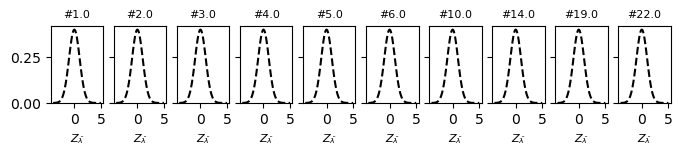

In [7]:
fig, axs = subplots(figsize=(8,1),ncols=length(lineages),sharey=true,sharex=true)
for i in eachindex(lineages)
    ax = axs[i-1]
    d = sims[sims.lineage .==lineages[i],:]
    d = sims[sims.σDN .==0.0,:]
    ax.hist((d.λ .- mean(d.λ)) ./ std(d.λ),10,density=true)
    xrng = collect(-4:0.1:5)
    ax.plot(xrng,1.0 ./sqrt(2 .*π) .* exp.(-xrng .^2/2),"k--")
    ax.set_title("#"*string(lineages[i]),fontsize=8)
    ax.set_xlabel(L"$Z_{\bar{\lambda}}$",fontsize=8)
end
fig

In [ ]:
s

## Visual Comparison of simulations to data

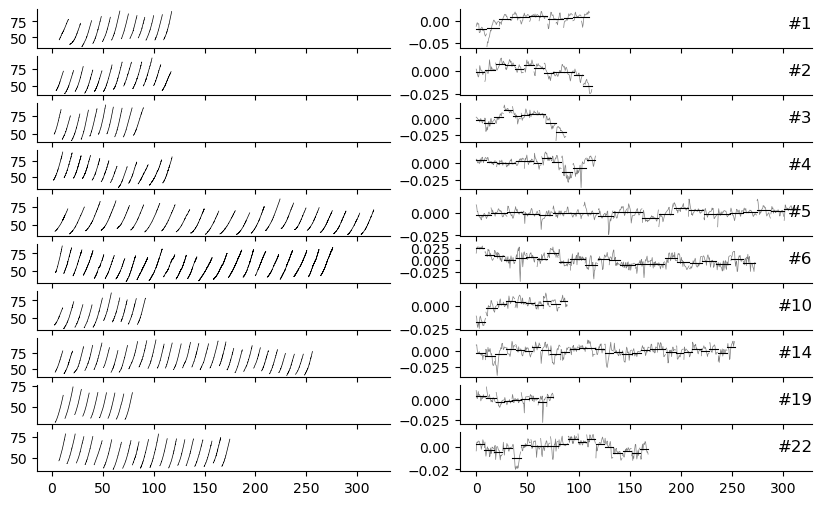

In [8]:
lw=0.5
fig,axs =subplots(figsize=(10,6),nrows=length(lineages),sharex="col",ncols=2)
for i in eachindex(lineages)
    lin = lineages[i]

    # ------------------------------------------
    ax = axs[i-1,0]

    sims1 = sims[sims.lineage_original .==lin,:]
    sims1 = sims1[sims1.σDN .== 0.0,:]
    
    
    #dd = data_gp[data_gp.lineage .==lin,:]
    dd = data_raw[data_raw.lineage .==lin,:]
    GrowthTraceTools.get_gen_times!(dd);
    #dd.λ = vcat([dd[dd.position .== p,:].matern32_flucs_x .+ dd[dd.position .== p,:].matern32_cell_x ./ dd[dd.position .== p,:gen_time][1]  for p in unique(dd.position)]...)
    #dd.λ = dd.matern32_flucs_x
    for j in 1:1
        ds = sims1[sims1.replicate .==j,:]
        [ax.plot(ds[ds.position .==p,:].time,ds[ds.position .==p,:].M,lw=0.5) for p in unique(ds.position)]
    end
    [ax.plot(dd[dd.position .==p,:].time,dd[dd.position .==p,:].M,"k",lw=0.5) for p in unique(dd.position)]
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)


    # ------------------------------------------
    ax = axs[i-1,1]

 

    for j in 1:1
        ds = sims1[sims1.replicate .==j,:]
        for p in unique(ds.position)
            t = ds[ds.position .==p,:].time
            λ =  ds[ds.position .==p,:].λ
            λ  = λ .- mean(ds.λ)
            ax.plot(t,λ ,"C"*string(Int64(p))*"-",lw=lw,alpha=0.5)
            ax.plot(t,mean(λ) .*ones(length(t)),"C"*string(Int64(p))*"-",lw=0.8)
        end
    end
    
    dd = data_gp[data_gp.lineage .==lin,:]
    GrowthTraceTools.get_gen_times!(dd);
    dd.λ = dd.matern32_flucs_x
    for p in unique(dd.position)
        t = dd[dd.position .==p,:].time
        ax.plot(t,dd[dd.position .==p,:].λ,"k-",lw=lw,alpha=0.5)
        ax.plot(t,mean(dd[dd.position .==p,:].λ) .*ones(length(t)),"k-",lw=0.8)
    end
    ax.set_title("#"*string(Int64(lin)),y=1.0, pad=-14,loc="right")
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)

  
end

#axs[length(lineages)-1,0].set_xlabel("time [hours]")
#axs[length(lineages)-1,1].set_xlabel("time [hours]")
savefig("./../figures/OU_vs_data.pdf")
fig

In [2]:
fig,ax =subplots(figsize=(10,2))
lw = 0.5
lin = lineages[3]
sims1 = sims[sims.lineage_original .==lin,:]
sims1 = sims1[sims1.ϕ .== 1.0,:]
sims1.time = sims1.time .- sims1.time[1]
for j in 1:1
    ds = sims1[sims1.replicate .==j,:]
    for p in unique(ds.position)
        t = ds[ds.position .==p,:].time
        λ =  ds[ds.position .==p,:].λ
        λ  = λ .- mean(ds.λ)
        ax.plot(t,λ ,"C0-",lw=lw,alpha=0.3)
        ax.plot(t,mean(λ) .*ones(length(t)),"C0-")
    end
end

dd = data_gp[data_gp.lineage .==lin,:]
GrowthTraceTools.get_gen_times!(dd);
dd.λ = dd.matern32_flucs_x
for p in unique(dd.position)
    t = dd[dd.position .==p,:].time
    ax.plot(t,dd[dd.position .==p,:].λ,"k-",lw=lw,alpha=0.3)
    ax.plot(t,mean(dd[dd.position .==p,:].λ) .*ones(length(t)),"k-")
end
ax.plot([0],[0],"k-",label=L"$\bar{\lambda}_{\rm flucs}$ (data)")
ax.plot([0],[0],"C0-",label=L"$\bar{\lambda}_{\rm flucs}$ (sims)")
ax.set_title("Lineage #"*string(Int64(lin)),y=1.0, pad=-14,loc="right")
ax.set_xlabel("time")
ax.legend(frameon=true)
savefig("./../figures/lineage_example.pdf")
fig


UndefVarError: UndefVarError: `lineages` not defined

## Look at summary statistics

In [11]:
var_df_sims = combine(groupby(sims_cells,[:lineage,:ϕ,:replicate]),:gr=> var => :gr_var,:gr=> mean => :gr_mean,:length=> (x -> x[1]) => :length)
var_df_data = combine(groupby(data_cells,:lineage),:gr=> var => :gr_var,:gr=> mean => :gr_mean,:length => mean => :length);
var_df_sims_gp = combine(groupby(sims_cells_gp,:lineage),:gr=> var => :gr_var,:gr=> mean => :gr_mean);
# var_df_sims.cv = var_df_sims.gr_var ./ var_df_data.gr_mean .^2
# var_df_data.cv = var_df_data.gr_var ./ var_df_data.gr_mean .^2
var_df_sims_gp.cv = var_df_sims_gp.gr_var ./ var_df_sims_gp.gr_mean .^2


sims_means_OU = combine(groupby(var_df_sims[var_df_sims.ϕ .== 1.0,:],:lineage),:gr_var => mean => :gr_var_avg).gr_var_avg
sims_std_OU = combine(groupby(var_df_sims[var_df_sims.ϕ .== 1.0,:],:lineage),:gr_var => std => :gr_var_std).gr_var_std; 
sims_means_DN = combine(groupby(var_df_sims[var_df_sims.ϕ .== 0.0,:],:lineage),:gr_var => mean => :gr_var_avg).gr_var_avg
sims_std_DN = combine(groupby(var_df_sims[var_df_sims.ϕ .== 0.0,:],:lineage),:gr_var => std => :gr_var_std).gr_var_std; 

CSV.write("./../output/var_table_data.csv",var_df_data)
CSV.write("./../output/var_table_sims.csv",var_df_sims)

"./../output/var_table_sims.csv"

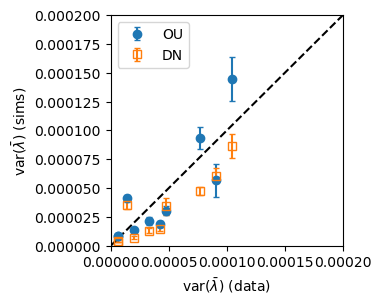

In [12]:
lengths = var_df_data.length
fig, ax= subplots(figsize=(3,3))
ax.errorbar(var_df_data.gr_var,sims_means_OU,yerr = sims_std_OU./sqrt(10),marker="o",linestyle="none",capsize=2,label="OU")
ax.errorbar(var_df_data.gr_var,sims_means_DN,yerr = sims_std_DN./sqrt(10),marker="s",linestyle="none",capsize=2,label="DN",fillstyle="none")

#ax.plot([0,0.002],[0,0.002*cov(var_df_data.gr_var,sims_means)/var(var_df_data.gr_var)])
#ax.plot(var_df_data.gr_var,var_df_sims_gp.gr_var ,"r.",label="Gaussian process")
ax.plot([0,0.002],[0,0.002],"k--")
#ax.loglog([mean(var_df_data.gr_var)],[mean(sims_means)],"C0+",label="average",markersize=10)
#ax.loglog([mean(var_df_data.gr_var)],[mean(var_sims_gp)],"C0s",label="average",markersize=10)
ax.set_xlabel(L"${\rm var}(\bar{\lambda})$ (data)")
ax.set_ylabel(L"${\rm var}(\bar{\lambda})$ (sims)")
ax.set_ylim([0,0.0002])
ax.set_xlim([0,0.0002])
ax.legend()
savefig("./../figures/varlambdabar-OU_vs_data.pdf",bbox_inches="tight")
fig
